In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive')
print("Current Directory:", os.getcwd())

import cv2
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

#Ball tracking
def track_ball(video_path):
    cap = cv2.VideoCapture(video_path)
    trajectory = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        blurred = cv2.GaussianBlur(frame, (11, 11), 0)
        hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

        lower = np.array([0, 100, 100])
        upper = np.array([10, 255, 255])
        mask = cv2.inRange(hsv, lower, upper)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest = max(contours, key=cv2.contourArea)
            (x, y), r = cv2.minEnclosingCircle(largest)
            if r > 2:
                trajectory.append((frame_count, int(x), int(y)))

    cap.release()
    return np.array(trajectory)


#Feature extractors
def fit_trajectory(trajectory):
    def parabola(x, a, b, c):
        return a * x**2 + b * x + c
    x, y = trajectory[:, 1], trajectory[:, 2]
    params, _ = curve_fit(parabola, x, y)
    return params, parabola

def detect_pitch_point(trajectory):
    y = trajectory[:, 2]
    dy = np.diff(y)
    return trajectory[np.argmin(dy)]

def detect_impact_point(trajectory):
    dx = np.diff(trajectory[:, 1])
    dy = np.diff(trajectory[:, 2])
    change = np.sqrt(dx**2 + dy**2)
    return trajectory[np.argmax(change)]

def estimate_speed(trajectory, fps=30):
    dist = np.sum(np.sqrt(np.diff(trajectory[:,1])**2 + np.diff(trajectory[:,2])**2))
    return dist / (len(trajectory) / fps)

def normalize_height(y, frame_height=480):
    return y / frame_height

def is_in_line(x, range_x=(300, 340)):
    return int(range_x[0] <= x <= range_x[1])


def extract_features(side_path, front_path):
    side_traj = track_ball(side_path)
    front_traj = track_ball(front_path)

    if len(side_traj) < 5 or len(front_traj) < 5:
        return None

    parab_params, parab_func = fit_trajectory(side_traj)
    bounce = detect_pitch_point(side_traj)
    impact = detect_impact_point(side_traj)
    front_impact = detect_impact_point(front_traj)

    features = {
        "ball_pitch_x": bounce[1],
        "ball_pitch_y": bounce[2],
        "impact_x": impact[1],
        "impact_y": impact[2],
        "speed": estimate_speed(side_traj),
        "trajectory_hits_stumps": int(parab_func(impact[1] + 50, *parab_params) < 250),
        "impact_in_line": is_in_line(front_impact[1]),
        "impact_height_norm": normalize_height(impact[2])
    }

    return features


    return features


#Process all videos and Save Final CSV
def process_all_videos(base_path="/content/drive/MyDrive/Videos"):
    final_data = []
    for label_folder, label in zip(["not_lbw", "lbw"], [0, 1]):
        folder_path = os.path.join(base_path, label_folder)
        files = sorted(os.listdir(folder_path))

        side_files = [f for f in files if f.startswith("sv_") and f.endswith(".mp4")]
        for side_file in side_files:
            index = side_file.replace("sv_", "").replace(".mp4", "")
            front_file = f"fv_{index}.mp4"
            side_path = os.path.join(folder_path, side_file)
            front_path = os.path.join(folder_path, front_file)

            if not os.path.exists(front_path):
                print(f"❌ Missing front video for {side_file}, skipping.")
                continue

            print(f"🔍 Processing pair: {side_file} + {front_file}")

            side_traj = track_ball(side_path)
            front_traj = track_ball(front_path)

            if len(side_traj) < 5:
                print(f"⚠️  Not enough points in side view for {side_file} ({len(side_traj)} points). Skipping.")
                continue
            if len(front_traj) < 5:
                print(f"⚠️  Not enough points in front view for {front_file} ({len(front_traj)} points). Skipping.")
                continue

            features = extract_features(side_path, front_path)
            if features:
                features["label"] = label
                features["video_index"] = index
                final_data.append(features)
            else:
                print(f"⚠️  Feature extraction failed for {side_file}.")

    df = pd.DataFrame(final_data)
    df.to_csv("final_lbw_dataset.csv", index=False)
    print("✅ Saved final_lbw_dataset.csv with", len(df), "entries.")
    return df

df = process_all_videos("Videos")

#Download the CSV file from Colab
from google.colab import files
files.download("final_lbw_dataset.csv")


Mounted at /content/drive
Current Directory: /content/drive/MyDrive
🔍 Processing pair: sv_1.mp4 + fv_1.mp4
⚠️  Not enough points in front view for fv_1.mp4 (1 points). Skipping.
🔍 Processing pair: sv_11.mp4 + fv_11.mp4
🔍 Processing pair: sv_12.mp4 + fv_12.mp4
🔍 Processing pair: sv_13.mp4 + fv_13.mp4
🔍 Processing pair: sv_15.mp4 + fv_15.mp4
🔍 Processing pair: sv_16.mp4 + fv_16.mp4
🔍 Processing pair: sv_17.mp4 + fv_17.mp4
🔍 Processing pair: sv_19.mp4 + fv_19.mp4
🔍 Processing pair: sv_2.mp4 + fv_2.mp4
⚠️  Not enough points in side view for sv_2.mp4 (3 points). Skipping.
🔍 Processing pair: sv_20.mp4 + fv_20.mp4
🔍 Processing pair: sv_22.mp4 + fv_22.mp4
🔍 Processing pair: sv_23.mp4 + fv_23.mp4
🔍 Processing pair: sv_24.mp4 + fv_24.mp4
🔍 Processing pair: sv_29.mp4 + fv_29.mp4
🔍 Processing pair: sv_3.mp4 + fv_3.mp4
⚠️  Not enough points in front view for fv_3.mp4 (4 points). Skipping.
🔍 Processing pair: sv_31.mp4 + fv_31.mp4
🔍 Processing pair: sv_32.mp4 + fv_32.mp4
🔍 Processing pair: sv_33.mp4 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Class Distribution:
Class 0: 31 samples
Class 1: 13 samples

Class Weights: {0: np.float64(0.717391304347826), 1: np.float64(1.65)}
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - binary_accuracy: 0.2921 - loss: 0.9038 - precision: 0.2694 - recall: 0.8722 - val_binary_accuracy: 0.5455 - val_loss: 0.7670 - val_precision: 0.3750 - val_recall: 1.0000
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - binary_accuracy: 0.2536 - loss: 0.8612 - precision: 0.2500 - recall: 0.8097 - val_binary_accuracy: 0.5455 - val_loss: 0.7534 - val_precision: 0.3750 - val_recall: 1.0000
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - binary_accuracy: 0.3688 - loss: 0.7713 - precision: 0.3125 - recall: 0.8750 - val_binary_accuracy: 0.6364 - val_loss: 0.7438 - val_precision: 0.4286 - val_recall: 1.0000
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - binary_accuracy: 0.3459 - loss: 0.7587 - precision: 0.2994 - recall: 0.9250 - val_binary_accuracy: 0.6364 - val_loss: 0.7354 - val_precision: 0.4286 

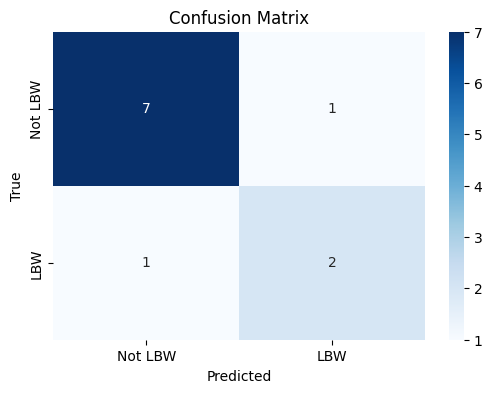

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


#Load data
csv_path = "/content/final_lbw_dataset (2).csv"
df = pd.read_csv(csv_path)

#Drop unused features
df = df.drop(columns=["trajectory_hits_stumps", "impact_in_line", "video_index"])

#Split features and labels
X = df.drop(columns=["label"]).values
y = df["label"].values

#Print class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class Distribution:")
for label, count in zip(unique, counts):
    print(f"Class {int(label)}: {count} samples")

#Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)


# Compute Class Weights
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}
print("\nClass Weights:", class_weights)

# Define TensorFlow Model
model = models.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Training
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=16,
                    validation_data=(X_test, y_test),
                    class_weight=class_weights,
                    callbacks=[early_stop],
                    verbose=1)

# Evaluate and Report
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not LBW", "LBW"],
            yticklabels=["Not LBW", "LBW"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
